In [1]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator

In [2]:
load_dotenv()
import os

In [3]:
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
model=ChatGroq(model="llama3-70b-8192",api_key=GROQ_API_KEY)

In [4]:
class EvalutionScema(BaseModel):
    feedback:str=Field(description='Deatailed Feedback for eassy')
    score: int=Field(description='Score out of 10',ge=0,le=10)

In [5]:
structured_model=model.with_structured_output(EvalutionScema)

In [6]:
eassy="""Artificial Intelligence (AI) is transforming the world, and India is no exception. With its vast population, growing digital infrastructure, and thriving technology sector, India is uniquely positioned to leverage AI for economic growth, social development, and governance. AI is no longer a futuristic concept—it is already influencing healthcare, agriculture, education, finance, and even public administration in India.

1. AI in Governance and Public Services
The Indian government is using AI to improve citizen services and governance. For example, AI-powered chatbots are helping citizens access government schemes easily, while facial recognition systems are being used for security and identification. Projects like Digital India and the National AI Strategy (AI for All) aim to make AI accessible for inclusive growth.

2. AI in Healthcare
AI is helping doctors diagnose diseases faster, improve treatment plans, and predict health risks. During the COVID-19 pandemic, AI-based models were used for contact tracing and vaccine distribution planning. Telemedicine platforms with AI chatbots are making healthcare more affordable and accessible in rural areas.

3. AI in Agriculture
Agriculture remains the backbone of India’s economy, and AI is improving productivity. AI-driven drones and satellite imagery help farmers monitor crop health, detect pests, and optimize irrigation. Predictive analytics also helps farmers make better decisions about sowing and harvesting.

4. AI in Education
AI is personalizing learning experiences for students. Adaptive learning platforms provide customized lessons, while language translation tools help break barriers in India’s multilingual education system. AI tutors and chatbots are assisting teachers and students in remote areas.

5. AI in Industry and Economy
AI is driving automation in manufacturing, logistics, and financial services. It helps businesses analyze large datasets, improve customer service, and detect fraud. Indian startups are increasingly adopting AI to create innovative solutions, boosting the digital economy.

6. Challenges of AI in India
Despite its benefits, AI adoption in India faces challenges like lack of skilled workforce, inadequate data infrastructure, and ethical concerns regarding privacy and job displacement. To fully harness AI, India must invest in education, research, and policy frameworks.

Conclusion
AI has immense potential to transform India’s economy and society. From smart governance to precision farming, from improving healthcare to making education accessible, AI can bridge gaps and create opportunities for millions. However, to ensure inclusive growth, India must balance innovation with ethics and create policies that make AI beneficial for all.

In the future, AI will not just be a technological tool but a key driver of India’s journey towards becoming a global leader in the digital era."""

In [7]:
prompt=f"evaluate the language quality of the following  eaasy and provide a feedback a assign a score out of 10 \n {eassy}"
answer=structured_model.invoke(prompt)

In [8]:
answer

EvalutionScema(feedback='The language quality of the essay is excellent. The writer has demonstrated a clear understanding of the topic and has presented a well-structured and coherent argument. The use of transitions and connectors is effective in linking the different paragraphs together. The language is formal and academic, and the vocabulary is rich and varied. The writer has also provided relevant examples and evidence to support their claims.', score=9)

# Workflows-UPSC

In [9]:
class UPSCState(TypedDict):
    eassy:str
    language_feedback:str
    analysis_feedback:str
    clarrity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[list[int],operator.add]
    avg_score:float


In [10]:
def evaluate_language(state:UPSCState):
    prompt=f"evaluate the language quality of the following  eaasy and provide a feedback a assign a score out of 10 \n {state['eassy']}"
    output=structured_model.invoke(prompt)

    return {'language_feedback':output.feedback,'individual_scores':[output.score]}

In [11]:
def evaluate_analysis(state:UPSCState):
    prompt=f"evaluate the deapth of analysis of the following  eaasy and provide a feedback a assign a score out of 10 \n {state['eassy']}"
    output=structured_model.invoke(prompt)

    return {'analysis_feedback':output.feedback,'individual_scores':[output.score]}

In [12]:
def evaluate_clarity(state:UPSCState):
    prompt=f"evaluate the clarity of thought of the following  eaasy and provide a feedback a assign a score out of 10 \n {state['eassy']}"
    output=structured_model.invoke(prompt)

    return {'clarrity_feedback':output.feedback,'individual_scores':[output.score]}

In [20]:
def final_evaluation(state: UPSCState):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarrity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # avg calculate
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [21]:
graph=StateGraph(UPSCState)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_clarity',evaluate_clarity)
graph.add_node('final_evalution',final_evaluation)

#add edages
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_clarity')

graph.add_edge('evaluate_language','final_evalution')
graph.add_edge('evaluate_analysis','final_evalution')
graph.add_edge('evaluate_clarity','final_evalution')

graph.add_edge('final_evalution',END)

workflow=graph.compile()

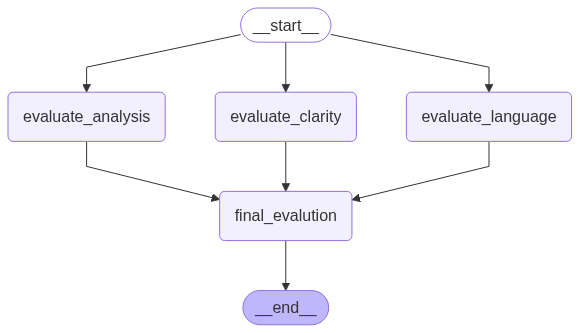

In [22]:
workflow

In [23]:
initial_state={"eassy":eassy}

final_out=workflow.invoke(initial_state)

print(final_out)


{'eassy': 'Artificial Intelligence (AI) is transforming the world, and India is no exception. With its vast population, growing digital infrastructure, and thriving technology sector, India is uniquely positioned to leverage AI for economic growth, social development, and governance. AI is no longer a futuristic concept—it is already influencing healthcare, agriculture, education, finance, and even public administration in India.\n\n1. AI in Governance and Public Services\nThe Indian government is using AI to improve citizen services and governance. For example, AI-powered chatbots are helping citizens access government schemes easily, while facial recognition systems are being used for security and identification. Projects like Digital India and the National AI Strategy (AI for All) aim to make AI accessible for inclusive growth.\n\n2. AI in Healthcare\nAI is helping doctors diagnose diseases faster, improve treatment plans, and predict health risks. During the COVID-19 pandemic, AI-b